In [1]:
%load_ext autoreload
%autoreload 2
%autoreload 2

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import table
from astropy import cosmology
from astropy.io import fits

from ekfplot import plot as ek
from ekfplot import colors as ec
from ekfphys import observer, calibrations
from ekfstats import sampling, functions

from agrias import utils
import reader

cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [85]:
meriancolor = ec.ColorBase('tab:red')

In [4]:
merian = table.Table(fits.getdata('/Users/kadofong/Downloads/Merian_DR1_photoz_EAZY_v1.2.fits',1))

In [248]:
ms = reader.merianselect ( merian, maglim=28. )

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 28.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


/Users/kadofong/work/projects/merian/agrias/notebooks/reader.py:58: RuntimeWarning: overflow encountered in power
  av = 10.**np.poly1d(saga_gr_av_coeffs)(gr)


In [249]:
use_galex_direct = True

if use_galex_direct:
    _galex = pd.read_csv('../local_data/output/galex_photometry.csv', index_col=0)
    print(f'Direct photometry for {_galex.dropna().shape[0]} galaxies found.')
else:
    _galex = reader.galexcrossmatch ()    
    
overlap = ms.index.intersection(_galex.index)

merian_sources = ms.reindex(overlap)

if not use_galex_direct:
    _galex = _galex.sort_values('fuv_exptime', ascending=False)
galex = _galex.loc[~_galex.index.duplicated(keep='first')].reindex(overlap)#.reset_index()

if use_galex_direct:
    galex['fuv_mag'] = -2.5*np.log10(galex['flux_fuv']/3631.)
    galex['nuv_mag'] = -2.5*np.log10(galex['flux_nuv']/3631.)
else:
    galex['flux_fuv'] = np.where(galex['fuv_mag']>0., 10.**(galex['fuv_mag']/-2.5) * 3631., np.NaN)
    galex['flux_nuv'] = np.where(galex['nuv_mag']>0., 10.**(galex['nuv_mag']/-2.5) * 3631., np.NaN)
    galex['u_flux_fuv'] = (galex['fuv_mag']/galex['fuv_magerr'])**-1 * galex['flux_fuv']
    galex['u_flux_nuv'] = (galex['nuv_mag']/galex['nuv_magerr'])**-1 * galex['flux_nuv']
#merian_sources = table.Table.from_pandas(merian_sources.reset_index())

Direct photometry for 15443 galaxies found.


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [250]:
galex_ms = reader.galexcrossmatch ()   
galex_ms = galex_ms.sort_values('fuv_exptime', ascending=False)
galex_ms = galex_ms.loc[~galex_ms.index.duplicated(keep='first')]
galex_ms.loc[galex_ms['fuv_mag']<0., 'fuv_mag'] = np.NaN

In [251]:
out = reader.compute_halphacorrections(merian_sources, use_dustengine=False)
emission_correction, ge_correction, dust_correction, aperture_correction = out

Computed line contamination in 0.0 seconds.
Computed Galactic extinction in 0.1 seconds.
Computed internal extinction in 0.1 seconds.
Computed aperture correction in 0.0 seconds.


In [252]:
galex = reader.galex_luminosities(
    galex, 
    merian_sources['z_phot'].values, 
    ge_correction,# if not use_galex_direct else None, 
    dust_correction 
)
galex = galex.to_pandas()

In [253]:
catalog_halum = pd.read_csv ( '/Users/kadofong/Desktop/merian_catalog_halum.csv', index_col=0)
assert catalog_halum.shape[0] == ms.shape[0]

In [254]:
lha_df = pd.read_csv('../local_data/output/lha_df.csv', index_col=0)
lha_df = lha_df.reindex(merian_sources.index)

direct2cat_change =  np.log10(lha_df['LHa']*1e40/catalog_halum['LHa'])
lha_df.loc[abs(direct2cat_change)>1.] = np.NaN

print(f'Direct Ha photometry found for {lha_df.dropna().shape[0]}/{lha_df.shape[0]} sources.')

Direct Ha photometry found for 14888/25046 sources.


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [257]:
lha_df = catalog_halum

## H$\alpha$ Luminosity Function

In [308]:
# targeting completeness is 1 because we don't have to target
# \\ Imaging completeness

# \\ Redshift success 

In [288]:
surveyarea=234.*u.deg**2
solidangle_fillfactor = ((4.*np.pi*u.sr)/surveyarea).decompose().value
sample_fillfactor = lha_df.shape[0] / lha_df.dropna().shape[0]

In [289]:
dlum = cosmo.luminosity_distance(ms.reindex(lha_df.index)['z_phot'].values).value
haflux = lha_df['LHa'] * 1e40/ (4.*np.pi*dlum**2)
u_haflux = lha_df['u_LHa'] * 1e40 / (4.*np.pi*dlum**2)
#max_dlum = np.sqrt(lha_df['u_LHa']/(4.*np.pi*haflux))
max_dlum = np.sqrt(lha_df['LHa']*1e40/(4.*np.pi*u_haflux))
survey_max_dlum = cosmo.luminosity_distance(0.09).value
survey_min_dlum = cosmo.luminosity_distance(0.07).value
max_dlum = np.where(max_dlum>survey_max_dlum, survey_max_dlum, max_dlum)

probed_volume = 4./3. * np.pi * ( max_dlum**3 - survey_min_dlum**3 ) # Mpc^3

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [303]:
def read_gama (prefix=None, suffix=None):
    if prefix is None:
        prefix = 'GAMA'
    if suffix is None:
        suffix = ''
    gama = pd.read_csv(f'/Users/kadofong/Downloads/{prefix}{suffix}_HALF.csv', names=['logLHa_inWatts', 'cts'])
    gama['logLHa'] = gama['logLHa_inWatts'] + 7.
    return gama

In [304]:
bins = np.linspace (38.5, 42.5, 50)
binwidth = np.diff(bins)[0]
loglha = np.log10(lha_df['LHa'])# + 40.
cts, _ = np.histogram( loglha, bins=bins, weights=1./probed_volume*solidangle_fillfactor/binwidth*sample_fillfactor )


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_24555/2358375031.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.step ( sampling.midpts(bins), np.log10(cts))
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_24555/2358375031.py:1: RuntimeWarning: invalid value encountered in log10
  plt.step ( sampling.midpts(bins), np.log10(cts))


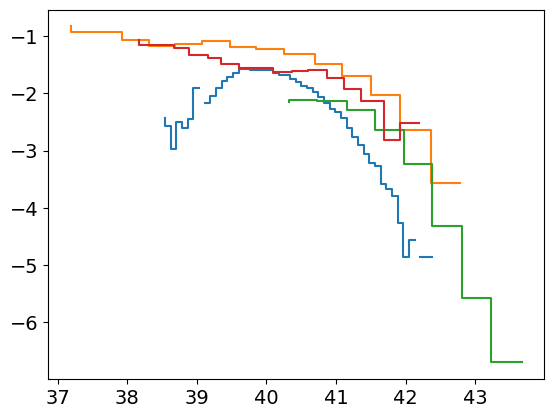

In [310]:
plt.step ( sampling.midpts(bins), np.log10(cts))

gama_lz = read_gama ()
plt.step ( gama_lz['logLHa'], gama_lz['cts'] )

gama_highz = read_gama(suffix='_0p1-0p15')
plt.step ( gama_highz['logLHa'], gama_highz['cts'] )

westra = read_gama(prefix='Westra2010')
plt.step ( westra['logLHa'], westra['cts'] )


In [106]:
cosmology.z_at_value ( cosmo.luminosity_distance, 108*u.Mpc)

<Quantity 0.02474697 redshift>

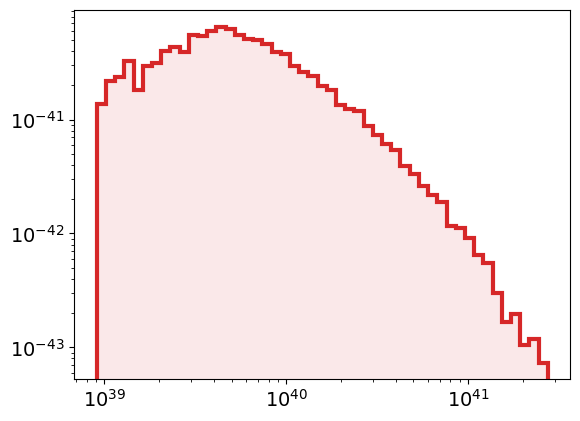

In [125]:
ax, (cts, bins,_) = ek.hist(lha_df['LHa']*1e40, bins=50, bintype='log', 
                            density=True, alpha=0.1, lw=3,color=meriancolor.base)

plt.yscale('log')

In [76]:
from carpenter import conventions, pixels
from astropy import coordinates
from astropy import units as u
def mk_skyobj ( row ):
    return coordinates.SkyCoord(row.RA, row.DEC, unit='deg')

In [79]:
mid = lha_df.loc[abs(direct2cat_change)>1.].index[5]
row = ms.loc[mid]
objid = conventions.produce_merianobjectname(row.RA, row.DEC)
halphaim = fits.open(f'../local_data/cutouts/halpha/{objid}.fits')

(<matplotlib.contour.QuadContourSet at 0x11ffc25f0>, <Axes: >)

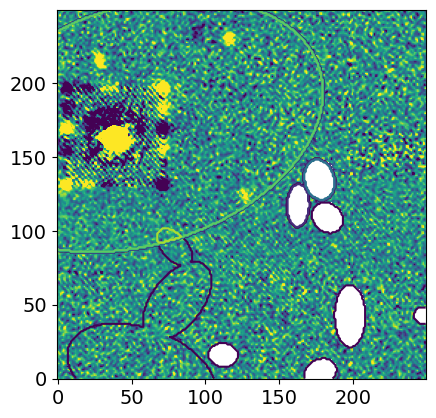

In [80]:
ek.imshow(halphaim['HALPHASB'].data)
ek.contour(halphaim['SEGMAP'].data)

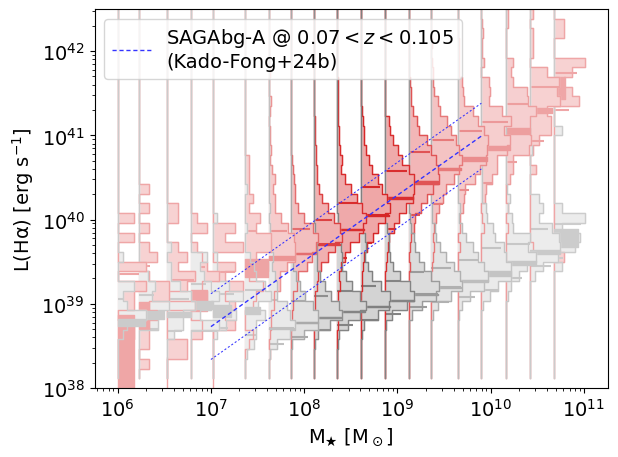

In [84]:
apercorr = ms['i_cModelFlux_Merian']/ms['i_gaap1p0Flux_aperCorr_Merian']
xd = 10.**ms['logmass_gaap1p0'] * apercorr
yd = lha_df['LHa']*1e40

yd = np.where(yd==0, np.NaN,yd)
u_yd = lha_df['u_LHa']*1e40
xd,yd,u_yd = functions.fmasker(xd,yd,u_yd)


xbins = np.logspace(6.,11.,20)
ybins = np.logspace(38.,42.5,40)
_=ek.histstack(
    xd,
    yd,
    xbins=xbins,
    ybins=ybins,
    edgecolor=meriancolor.base,
    quantilecolor=meriancolor.base,
    facecolor=meriancolor.modulate(0.3).base,
    label='Merian'
)
_=ek.histstack(
    xd,
    u_yd,
    xbins=xbins,
    ybins=ybins,
    edgecolor=ec.ColorBase('k').modulate(0.5).base,
    quantilecolor=ec.ColorBase('k').modulate(0.5).base,
)

logmstar_bins = np.linspace(7., 9.9,30)
saga_params = [0.78, -1.36, 0.39]
plt.plot(
    10.**logmstar_bins,
    calibrations.SFR2LHa(10.**(saga_params[0]*(logmstar_bins-8.5) + saga_params[1])),
    dashes=[3,2],
    lw=1,
    color=ec.ColorBase('b').modulate(0.1).base,
    label=r'''SAGAbg-A @ $0.07<z<0.105$
(Kado-Fong+24b)'''
)
for sign in [-1.,1.]:
    plt.plot(
        10.**logmstar_bins,
        calibrations.SFR2LHa(10.**(saga_params[0]*(logmstar_bins-8.5) + saga_params[1] + sign*saga_params[2])),
        dashes=[2,2],
        lw=0.75,
        color=ec.ColorBase('b').modulate(0.1).base,
    )    

ek.loglog()
plt.ylim(ybins.min(),ybins.max())
plt.legend(loc='upper left')
plt.xlabel(ek.common_labels['mstar'])
plt.ylabel(ek.common_labels['halum'])

plt.tight_layout ()
plt.savefig('../../../sfr_calibrators/figures/data_validation/Merian_directSFS.png')